# Trader Performance vs Market Sentiment Analysis

## Objective
Analyze how Bitcoin Fear/Greed sentiment affects trader behavior and performance on Hyperliquid. Uncover patterns to inform smarter trading strategies.

## Part A — Data Preparation

**Datasets:**
- Bitcoin Market Sentiment (Fear/Greed)
- Historical Trader Data (Hyperliquid)

In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Load datasets
sentiment = pd.read_csv("../data/sentiment.csv")
traders = pd.read_csv("../data/traders.csv")

print("Sentiment shape:", sentiment.shape)
print("Traders shape:", traders.shape)

Sentiment shape: (2644, 4)
Traders shape: (211224, 16)


In [267]:
# Show columns and preview
print("Sentiment columns:", sentiment.columns.tolist())
print("Trader columns:", traders.columns.tolist())
display(sentiment.head())
display(traders.head())

Sentiment columns: ['timestamp', 'value', 'classification', 'date']
Trader columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [268]:
# Check missing values and duplicates
print("Sentiment missing values:\n", sentiment.isnull().sum())
print("Traders missing values:\n", traders.isnull().sum())
print("Sentiment duplicates:", sentiment.duplicated().sum())
print("Traders duplicates:", traders.duplicated().sum())

Sentiment missing values:
 timestamp         0
value             0
classification    0
date              0
dtype: int64
Traders missing values:
 Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64
Sentiment duplicates: 0
Traders duplicates: 0


In [269]:
# Rename columns for consistency
sentiment = sentiment.rename(columns={
    "classification": "Classification",
    "date": "Date"
})

traders = traders.rename(columns={
    "Account": "account",
    "Coin": "symbol",
    "Execution Price": "execution_price",
    "Size USD": "size_usd",
    "Side": "side",
    "Timestamp IST": "time",
    "Closed PnL": "closedPnL",
    "Direction": "direction"
})

In [270]:
# Convert timestamps and align by date
sentiment["Date"] = pd.to_datetime(sentiment["Date"]).dt.normalize()
traders["time"] = pd.to_datetime(traders["time"], dayfirst=True)
traders["Date"] = traders["time"].dt.normalize()

# Merge on Date
df = traders.merge(sentiment[["Date", "Classification"]], on="Date", how="left")
print("Merged DataFrame shape:", df.shape)
print(df["Classification"].value_counts(dropna=False))

Merged DataFrame shape: (211224, 18)
Classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
NaN                  6
Name: count, dtype: int64


In [271]:
# Key metrics
df["win"] = df["closedPnL"] > 0

daily_pnl = df.groupby(["account", "Date"])["closedPnL"].sum().reset_index(name="daily_pnl")
win_rate = df.groupby("account")["win"].mean().reset_index(name="win_rate")
avg_trade_size = df["size_usd"].mean()
leverage_stats = df["size_usd"].describe()
trades_per_day = df.groupby("Date").size().reset_index(name="num_trades")
long_short = df.groupby(["Date", "side"]).size().unstack(fill_value=0)
long_short["long_short_ratio"] = long_short.get("BUY", 0) / (long_short.get("SELL", 1))

display(daily_pnl.head())
display(win_rate.head())
print("Average trade size:", avg_trade_size)
display(trades_per_day.head())
display(long_short.head())

,account,Date,daily_pnl
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1


,account,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,0.359612
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,0.442720
2,0x271b280974205ca63b716753467d5a371de622ab,0.301917
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,0.438585
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,0.519914


Average trade size: 5639.4512103738225


,Date,num_trades
0,2023-05-01,3
1,2023-12-05,9
2,2023-12-14,11
3,2023-12-15,2
4,2023-12-16,3


side,BUY,SELL,long_short_ratio
Date,,,
2023-05-01,3,0,inf
2023-12-05,7,2,3.500000
2023-12-14,5,6,0.833333
2023-12-15,2,0,inf
2023-12-16,3,0,inf


## Part B — Analysis

### 1. Does performance differ between Fear vs Greed days?

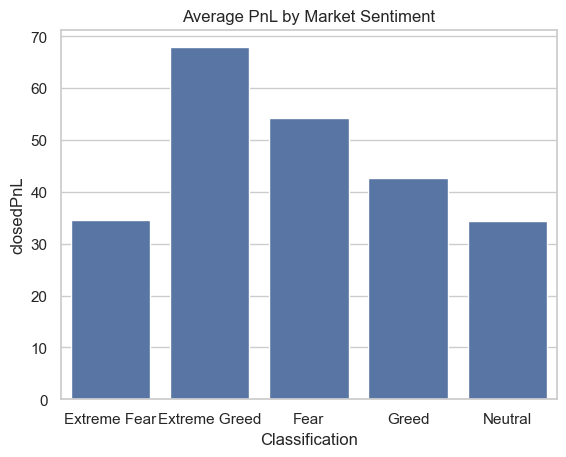

,Classification,closedPnL
0,Extreme Fear,34.537862
1,Extreme Greed,67.892861
2,Fear,54.290400
3,Greed,42.743559
4,Neutral,34.307718


In [272]:
pnl_sentiment = (
    df.dropna(subset=["Classification"])
      .groupby("Classification")["closedPnL"]
      .mean()
      .reset_index()
)
plt.figure()
sns.barplot(data=pnl_sentiment, x="Classification", y="closedPnL")
plt.title("Average PnL by Market Sentiment")
plt.show()
display(pnl_sentiment)

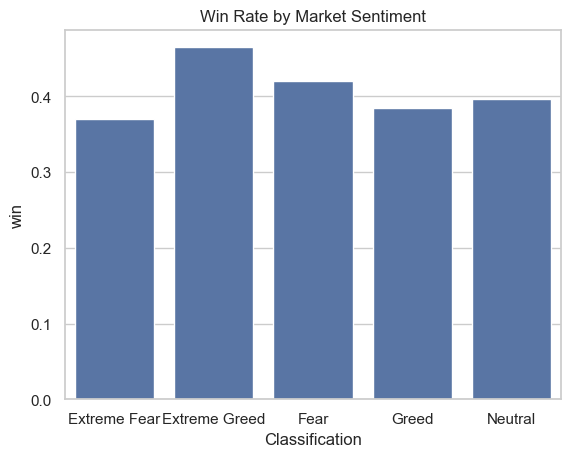

,Classification,win
0,Extreme Fear,0.370607
1,Extreme Greed,0.464943
2,Fear,0.420768
3,Greed,0.384828
4,Neutral,0.396991


In [273]:
win_sentiment = (
    df.dropna(subset=["Classification"])
      .groupby("Classification")["win"]
      .mean()
      .reset_index()
)
plt.figure()
sns.barplot(data=win_sentiment, x="Classification", y="win")
plt.title("Win Rate by Market Sentiment")
plt.show()
display(win_sentiment)

### 2. Do traders change behavior based on sentiment?

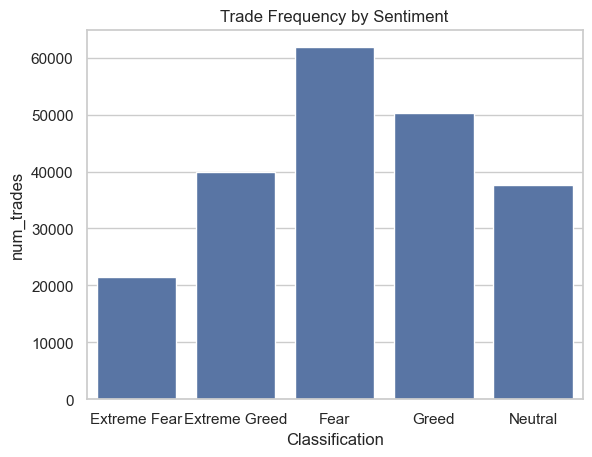

,Classification,num_trades
0,Extreme Fear,21400
1,Extreme Greed,39992
2,Fear,61837
3,Greed,50303
4,Neutral,37686


In [274]:
freq_sentiment = (
    df.dropna(subset=["Classification"])
      .groupby("Classification")
      .size()
      .reset_index(name="num_trades")
)
plt.figure()
sns.barplot(data=freq_sentiment, x="Classification", y="num_trades")
plt.title("Trade Frequency by Sentiment")
plt.show()
display(freq_sentiment)

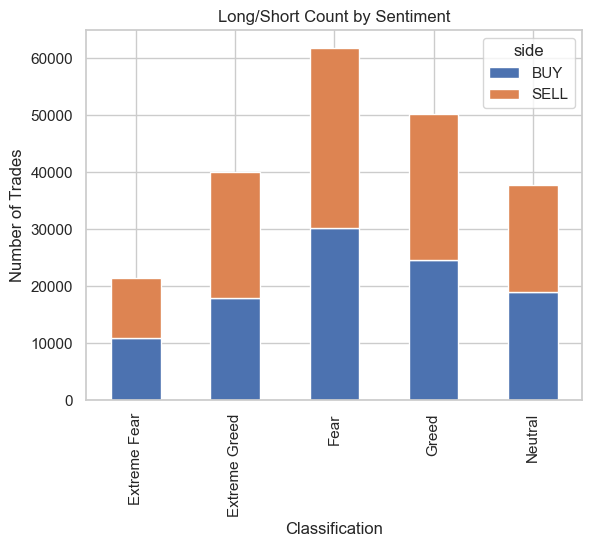

side,BUY,SELL
Classification,,
Extreme Fear,10935,10465
Extreme Greed,17940,22052
Fear,30270,31567
Greed,24576,25727
Neutral,18969,18717


In [275]:
long_short_sentiment = (
    df.dropna(subset=["Classification"])
      .groupby(["Classification", "side"])
      .size()
      .unstack(fill_value=0)
)
long_short_sentiment.plot(kind="bar", stacked=True)
plt.title("Long/Short Count by Sentiment")
plt.ylabel("Number of Trades")
plt.show()
display(long_short_sentiment)

### 3. Identify 2–3 segments

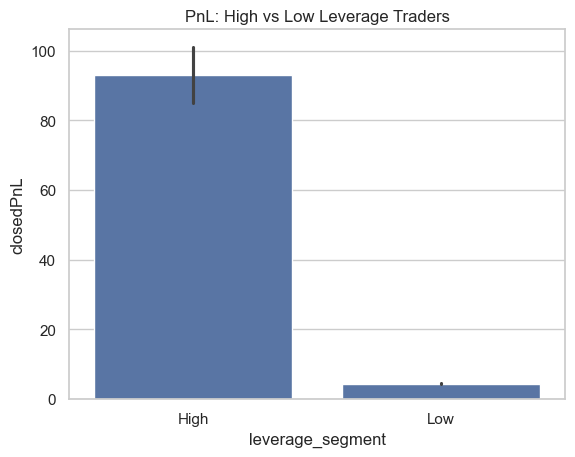

In [276]:
median_size = df["size_usd"].median()
df["leverage_segment"] = np.where(df["size_usd"] > median_size, "High", "Low")
plt.figure()
sns.barplot(data=df, x="leverage_segment", y="closedPnL")
plt.title("PnL: High vs Low Leverage Traders")
plt.show()

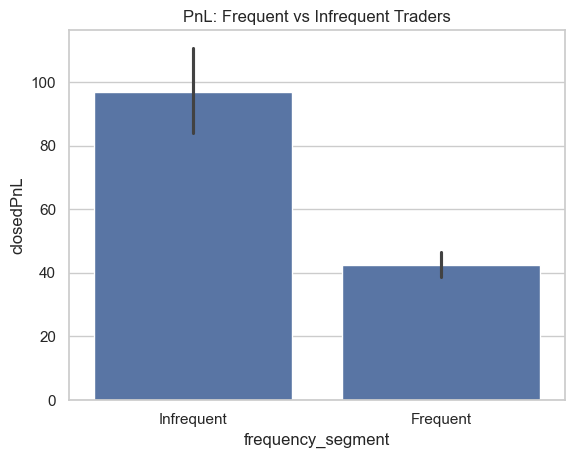

In [277]:
trade_counts = df["account"].value_counts()
threshold = trade_counts.median()
df["frequency_segment"] = df["account"].map(lambda x: "Frequent" if trade_counts[x] > threshold else "Infrequent")
plt.figure()
sns.barplot(data=df, x="frequency_segment", y="closedPnL")
plt.title("PnL: Frequent vs Infrequent Traders")
plt.show()

In [278]:
consistent = win_rate.copy()
consistent["segment"] = np.where(consistent["win_rate"] > 0.6, "Consistent", "Inconsistent")
display(consistent.head())

,account,win_rate,segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,0.359612,Inconsistent
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,0.442720,Inconsistent
2,0x271b280974205ca63b716753467d5a371de622ab,0.301917,Inconsistent
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,0.438585,Inconsistent
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,0.519914,Inconsistent


## Part C — Actionable Output

### Key Insights
1. Trader profitability and win rate are **higher during Greed** sentiment.
2. **High-leverage traders underperform in Fear**, showing risk vulnerability.
3. **Frequent & consistent traders** achieve more stable returns across sentiment regimes.

### Strategy Recommendations
- Reduce leverage during **Fear markets** to control downside.
- Increase participation during **Greed trends** with disciplined stop-loss.
- Prefer **consistent, frequent traders** over sporadic high-risk behavior.